In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime as d
from scipy import signal
from sklearn.linear_model import MultiTaskLasso, Ridge

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet
from beamformers import wnc_bisection as wnc
import loadSIO as sio

# Simpler MF test case, to check agreement between least squares solution and scikit solvers

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
# tStart = 1980
tStart = 3820

snapLength = 2
snapStep = 2
numSnaps = 23
sD = 54

wncMaxNorm = 2

frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencyNumber = 0
testFreq = frequencies[frequencyNumber]
tol = 1

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
rangeTime = experimentStart + d.timedelta(0, tStart)
sourceRange = swellEx_env.getRangeAtTime(rangeTime)
print(sourceRange)

1.097


In [3]:
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)
numSensors = sensorPosition.size
# Match field boundries
# zMax = enviornment.getProfile(0.).getZatInterface()[1]
zMax = 100
rMax = 1.5e3  # m
rMin = 500
numR = 50
numZ = 30

# Look Vector
lookR = 30
lookZ = 10

# Solver Parameters
decimation = 10
fB_width = 300

#Least squares
lamb = 10
alpha = 1e-2

In [4]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[rMin:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [5]:
# Synthetic data set
nm_model = Chinook(frequencies[frequencyNumber], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)

In [6]:
# Make normalized look vectors
lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
W = np.dstack(lookVectors)
W = W / np.linalg.norm(W, axis = 2)[:,:,None]
W = np.nan_to_num(W)
lookVector = np.squeeze(W[lookR, lookZ, :])
W = np.reshape(W, (numR * numZ, numSensors))

In [7]:
# setup for L1 minimization
X = W.T
numLook = X.shape[1]
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))

Y = lookVector
K = np.outer(lookVector, lookVector.conj())
YSplit = np.hstack((np.vstack((Y.real, Y.imag)),\
                    np.vstack((-Y.imag, Y.real)))).T

In [8]:
bart = [np.dot(lookVector, look) for look in X.T.conj()]

B_bart = np.abs(np.array(bart)) ** 2
B_bart = np.reshape(B_bart, (numR, numZ))
B_bart = 10 * np.log10(np.abs(np.array(B_bart).T))

In [9]:
W_ls = np.linalg.lstsq(X, Y)
B_ls = np.abs(np.nan_to_num(W_ls[0])) ** 2
B_ls = np.reshape(B_ls, (numR, numZ))
B_ls = 10 * np.log10(np.abs(np.array(B_ls).T) + np.spacing(1))

In [10]:
W_ls_reg = np.linalg.solve(X.conj().T.dot(X) + lamb * np.identity(numLook), X.conj().T.dot(Y))
B_ls_reg = np.abs(np.nan_to_num(W_ls_reg)) ** 2
B_ls_reg = np.reshape(B_ls_reg, (numR, numZ))
B_ls_reg = 10 * np.log10(np.abs(np.array(B_ls_reg).T) + np.spacing(1))

In [11]:
ridge_solver = Ridge(alpha=lamb, tol=1e-10, max_iter=1e6)
W_ridge = ridge_solver.fit(XSplit, YSplit)
stack1 = W_ridge.coef_[::2,:]
stack1 = np.squeeze(stack1[:,:numLook] + 1j * stack1[:,numLook:])

stack2 = W_ridge.coef_[1::2,:]
stack2 = np.squeeze(-1j * stack2[:,:numLook] + stack2[:,numLook:])

ridgeResult = np.mean(np.array((stack1, stack2)), axis = 0)
B_ls_ridge = np.abs(np.nan_to_num(ridgeResult)) ** 2
B_ls_ridge = np.reshape(B_ls_ridge, (numR, numZ))
B_ls_ridge = 10 * np.log10(np.abs(np.array(B_ls_ridge).T) + np.spacing(1))

In [12]:
lasso_solver = MultiTaskLasso(alpha=alpha)
W_lasso = lasso_solver.fit(XSplit, YSplit)

stack1 = W_lasso.coef_[::2,:]
stack1 = np.squeeze(stack1[:,:numLook] + 1j * stack1[:,numLook:])

stack2 = W_lasso.coef_[1::2,:]
stack2 = np.squeeze(-1j * stack2[:,:numLook] + stack2[:,numLook:])
lassoResult = stack1

(-6, 0)

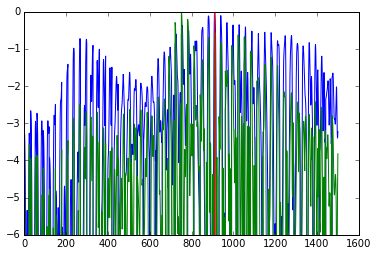

In [13]:
temp = 10 * np.log10(np.abs(bart) + np.spacing(1))
plt.plot(temp - np.max(temp))
temp = 10 * np.log10(np.abs(ridgeResult) + np.spacing(1))
plt.plot(temp - np.max(temp))
temp = 10 * np.log10(np.abs(stack1) + np.spacing(1))
plt.plot(temp - np.max(temp))
plt.ylim(-6,0)

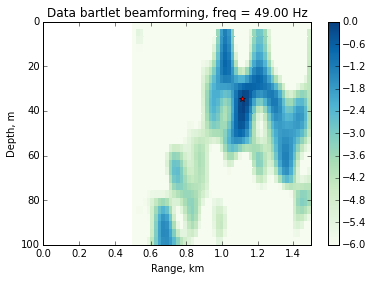

In [14]:
_ = plt.figure(0)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, B_bart, cmap = plt.cm.GnBu)
_ = plt.clim(-6, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(rPlot[lookR] / 1e3, zPlot[lookZ], 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

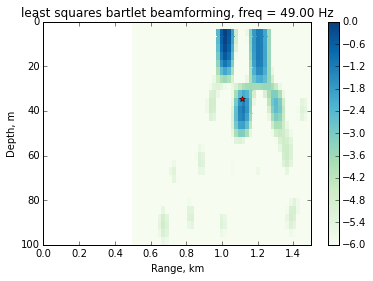

In [15]:
plot_B = B_ls_reg - np.max(B_ls_reg)
_ = plt.figure(1)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, plot_B, cmap = plt.cm.GnBu)
_ = plt.clim(-6, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax, 0)
_ = plt.title('least squares bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(rPlot[lookR] / 1e3, zPlot[lookZ], 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

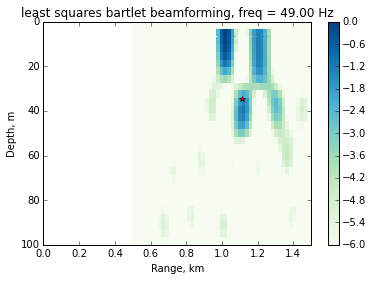

In [16]:
plot_B = B_ls_ridge - np.max(B_ls_ridge)
_ = plt.figure(1)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, plot_B, cmap = plt.cm.GnBu)
_ = plt.clim(-6, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax, 0)
_ = plt.title('least squares bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(rPlot[lookR] / 1e3, zPlot[lookZ], 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

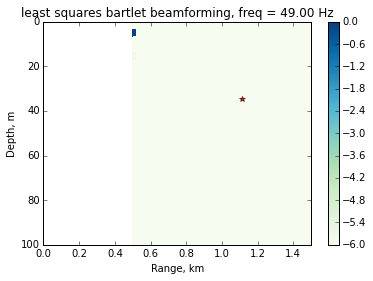

In [17]:
plot_B = B_ls - np.max(B_ls)
_ = plt.figure(1)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, plot_B, cmap = plt.cm.GnBu)
_ = plt.clim(-6, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax, 0)
_ = plt.title('least squares bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(rPlot[lookR] / 1e3, zPlot[lookZ], 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [18]:
def unstack_dB(solverOutput):
    """Unstack the messy output of a ML solver, and put into dB"""
    stack = solverOutput.coef_[::2,:]
    stack = stack[:,:numLook] + 1j * stack[:,numLook:]
    stack = np.linalg.norm(stack, 2, axis = 0)
    stack = np.nan_to_num(stack)
    B = reshape_DB(stack)
    return B